In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
SEQUENCE_LENGTH = 35 
NUM_JOINTS = 21
COORDS_PER_JOINT = 3
INPUT_SIZE = 2 * NUM_JOINTS * COORDS_PER_JOINT
HIDDEN_SIZE = 256
NUM_LAYERS_LSTM = 3
BIDIRECTIONAL = True
DROPOUT = 0.4
NUM_CLASSES = 6  
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 100
TEST_SIZE = 0.2
RANDOM_SEED = 42

In [4]:
GESTURE_CLASSES = ["A", "B", "C", "Xin_chao", "Cam_on", "Null"]
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

le = LabelEncoder().fit(GESTURE_CLASSES)

In [5]:
def normalize_hand(hand_data):
    if hand_data is None or hand_data[0]["x"] < 0:
        return [0.0] * (NUM_JOINTS * COORDS_PER_JOINT)

    wrist   = hand_data[0]
    mid_tip = hand_data[12] 

    dx = mid_tip["x"] - wrist["x"]
    dy = mid_tip["y"] - wrist["y"]
    dz = mid_tip["z"] - wrist["z"]
    scale = max(np.sqrt(dx*dx + dy*dy + dz*dz), 1e-3)

    normalized = []
    for p in hand_data:
        normalized.append((p["x"] - wrist["x"]) / scale)
        normalized.append((p["y"] - wrist["y"]) / scale)
        normalized.append((p["z"] - wrist["z"]) / scale)
    return normalized

In [6]:
def load_data():
    X, y = [], []

    NUM_FEATURES_PER_HAND = NUM_JOINTS * COORDS_PER_JOINT

    for gesture in GESTURE_CLASSES:
        gesture_dir = f"Data/label_{gesture}"
        if not os.path.exists(gesture_dir):
            print(f"Directory {gesture_dir} does not exist")
            continue

        for filename in os.listdir(gesture_dir):
            if not filename.endswith(".json"):
                continue

            filepath = os.path.join(gesture_dir, filename)
            with open(filepath, 'r') as f:
                frames = json.load(f)

            seq = []
            for frame in frames:
                left_norm  = normalize_hand(frame.get("left_hand"))
                right_norm = normalize_hand(frame.get("right_hand"))

                seq.append(left_norm + right_norm)

            if len(seq) >= SEQUENCE_LENGTH:
                seq = seq[-SEQUENCE_LENGTH:]
            else:
                pad_cnt = SEQUENCE_LENGTH - len(seq)
                pad = [[0.0] * (2 * NUM_FEATURES_PER_HAND) for _ in range(pad_cnt)]
                seq = pad + seq

            X.append(seq)
            y.append(gesture)

    X = np.array(X, dtype=np.float32)           
    y = le.transform(y).astype(np.int64)       
    return X, y

In [7]:
X, y = load_data()
print(f"Loaded data shapes: X={X.shape}, y={y.shape}")

Loaded data shapes: X=(235, 35, 126), y=(235,)


In [9]:
flat = X.reshape(-1, INPUT_SIZE)
mu, sigma = flat.mean(axis=0), flat.std(axis=0) + 1e-6
X = (X - mu) / sigma

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

In [13]:
class GestureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = GestureDataset(X_train, y_train)
val_ds   = GestureDataset(X_val,   y_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [28]:
class GestureModel(nn.Module):
    def __init__(
        self,
        input_size=2 * 21 * 3,
        hidden_sizes=(256, 128, 64),
        num_classes=len(GESTURE_CLASSES),
        dropout=0.3
    ):
        super().__init__()
        h1, h2, h3 = hidden_sizes

        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=h1,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.ln1 = nn.LayerNorm(h1)
        self.dropout1 = nn.Dropout(dropout)

        self.lstm2 = nn.LSTM(
            input_size=h1,
            hidden_size=h2,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.ln2 = nn.LayerNorm(h2)
        self.dropout2 = nn.Dropout(dropout)

        self.lstm3 = nn.LSTM(
            input_size=h2,
            hidden_size=h3,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.ln3 = nn.LayerNorm(h3)
        self.dropout3 = nn.Dropout(dropout)

        self.fc1 = nn.Linear(h3, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU(inplace=True)
        self.dropout_fc = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)       # (B, T, h1)
        x = self.ln1(x)            # LayerNorm theo hidden dim
        x = self.dropout1(x)

        x, _ = self.lstm2(x)       # (B, T, h2)
        x = self.ln2(x)
        x = self.dropout2(x)

        x, _ = self.lstm3(x)       # (B, T, h3)
        x = self.ln3(x)
        x = self.dropout3(x)

        x = x[:, -1, :]            # (B, h3)
        x = self.fc1(x)            # (B, 128)
        x = self.bn_fc1(x)         # BatchNorm1d across features
        x = self.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)            # (B, num_classes)
        return x

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GestureModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                                 factor=0.5, patience=5, verbose=True)

In [30]:
train_losses = []
val_losses   = []
val_accs     = []

best_val_loss = float("inf")
for epoch in range(1, NUM_EPOCHS + 1):
    # — Training —
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_ds)
    train_losses.append(train_loss)

    # — Validation —
    model.eval()
    val_loss = 0.0
    correct  = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            loss  = criterion(preds, yb)
            val_loss += loss.item() * Xb.size(0)
            correct  += (preds.argmax(dim=1) == yb).sum().item()
    val_loss /= len(val_ds)
    val_acc   = correct / len(val_ds)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.3f}")

    # Save best model
    if val_loss < best_val_loss:
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "mu": mu, "sigma": sigma,
            "label_encoder": le
        }, "best_hand_gesture_model.pth")
        best_val_loss = val_loss
print("Training complete. Best validation loss: {:.4f}".format(best_val_loss))

Epoch 001 | Train Loss: 1.6820 | Val Loss: 1.3203 | Val Acc: 0.638
Epoch 002 | Train Loss: 1.2457 | Val Loss: 1.0873 | Val Acc: 0.851
Epoch 003 | Train Loss: 1.0562 | Val Loss: 0.8913 | Val Acc: 0.851
Epoch 004 | Train Loss: 0.8912 | Val Loss: 0.7324 | Val Acc: 0.851
Epoch 005 | Train Loss: 0.7720 | Val Loss: 0.6336 | Val Acc: 0.872
Epoch 006 | Train Loss: 0.6562 | Val Loss: 0.5510 | Val Acc: 0.915
Epoch 007 | Train Loss: 0.5775 | Val Loss: 0.5250 | Val Acc: 0.915
Epoch 008 | Train Loss: 0.4570 | Val Loss: 0.4987 | Val Acc: 0.915
Epoch 009 | Train Loss: 0.3930 | Val Loss: 0.4804 | Val Acc: 0.915
Epoch 010 | Train Loss: 0.3419 | Val Loss: 0.4660 | Val Acc: 0.915
Epoch 011 | Train Loss: 0.3047 | Val Loss: 0.4709 | Val Acc: 0.915
Epoch 012 | Train Loss: 0.2605 | Val Loss: 0.4665 | Val Acc: 0.915
Epoch 013 | Train Loss: 0.2001 | Val Loss: 0.4680 | Val Acc: 0.915
Epoch 014 | Train Loss: 0.2093 | Val Loss: 0.4959 | Val Acc: 0.915
Epoch 015 | Train Loss: 0.2243 | Val Loss: 0.4684 | Val Acc: 0

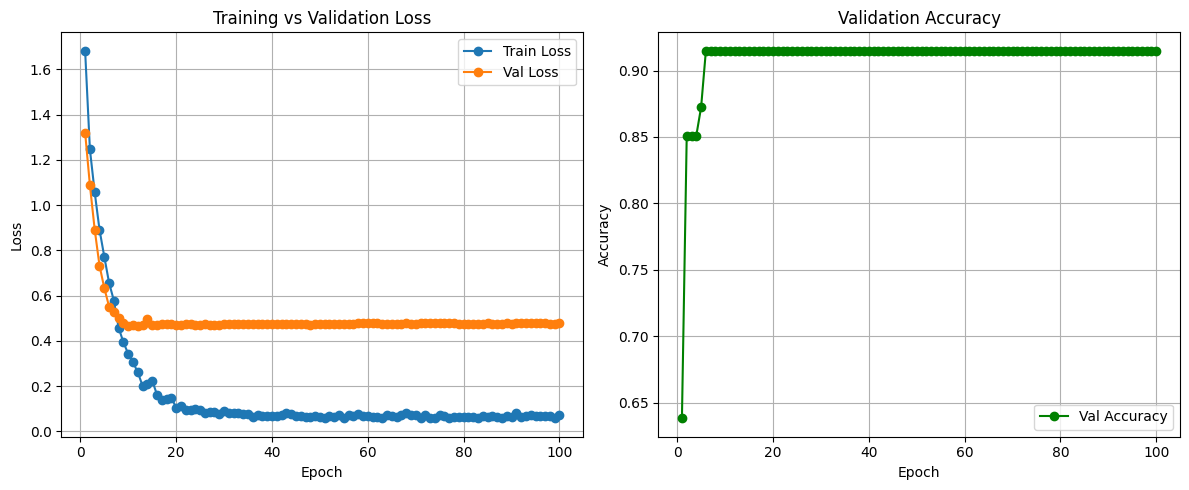

In [31]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Đường cong Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses,   label='Val Loss',   marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Đường cong Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, label='Val Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()